In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from losses import _reconstruction_loss
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model
from captum.attr import *

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, DTCWT_Mask, tuple_Attributer, create_images_high_attrs, compute_tuple_dim

## load data and model

In [2]:
# get dataloader and model
train_loader, model = load_dataloader_and_pretrained_model(p)

## set up wavelet transform and trim model

In [3]:
# wavelet transform
wt = Wavelet_Transform(wt_type='DTCWT', J=5)

# prepend transformation onto network
model_t = TrimModel(model, wt.inverse)

# input
torch.manual_seed(35)
im = iter(train_loader).next()[0][0:1].to(device)
im.requires_grad = True

# wavelet transform
im_t = wt(im)

# trim score
attributer = tuple_Attributer(model_t, attr_methods='InputXGradient')
attributions = attributer(im_t, target=1)

## sort in decreasing order

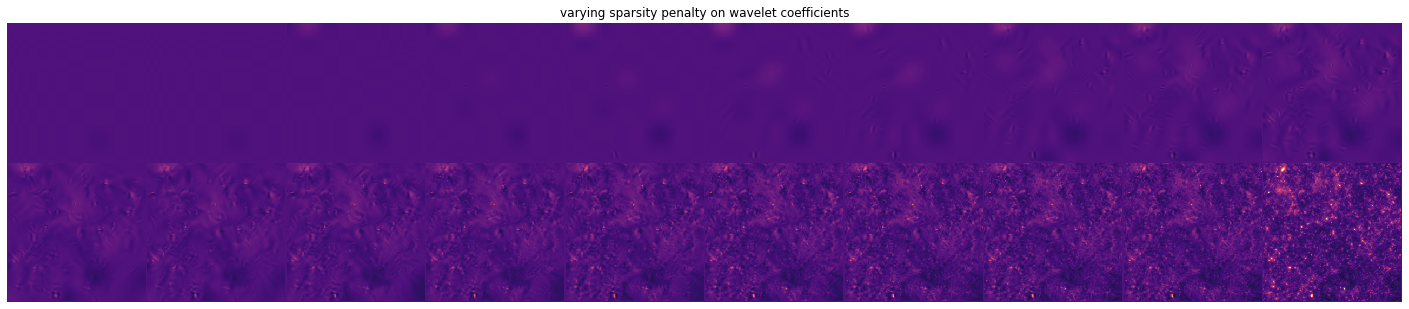

In [4]:
# sparsity level
num_sp = 20
tot_dim = compute_tuple_dim(im_t)
sp_level = np.geomspace(1, tot_dim, num_sp).astype(np.int)

# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
d = 256 + 2
mosaic = np.zeros((d*n_row,d*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        # sort attribution
        b = torch.tensor([])
        list_of_size = [0]

        for k in range(len(im_t)):
            a = attributions[k].cpu().reshape(-1)
            b = torch.cat((b,a))
            list_of_size.append(list_of_size[-1] + a.shape[0])
        sort_order = torch.argsort(b, descending=True) 
        m = torch.zeros_like(b)
        m[sort_order[:sp_level[indx]]] = 1

        list_of_m = []
        for k in range(len(im_t)):
            n0 = list_of_size[k]
            n1 = list_of_size[k+1]
            list_of_m.append(m[n0:n1].reshape(im_t[k].shape))

        wm_list = []
        for k in range(6):
            wm_list.append(torch.mul(list_of_m[k].to(device), im_t[k]))
        wm_list = tuple(wm_list)

        im_ = wt.inverse(wm_list)        
        mosaic[i*d:(i+1)*d,j*d:(j+1)*d] = np.pad(im_.squeeze().data.cpu().numpy(),(1,1),mode='constant')
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

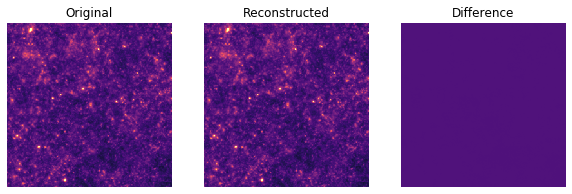

Recon Error: 1.0393032425781712e-06


In [5]:
# check reconstruction quality
viz_im_r(im[0,0], im_[0,0])
print('Recon Error:', torch.norm(im[0,0] - im_[0,0]).item())